Training model on complete dataset...


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0256
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0133
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0138
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0133
Epoch 5/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0129
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0130
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0123
Epoch 8/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0126
Epoch 9/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0121
Epoch 10/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0124
Epoch 11/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0118
Epoch 12/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0118
Epoch 13/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0116
Epoch 14/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0114
Epoch 15/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - lo

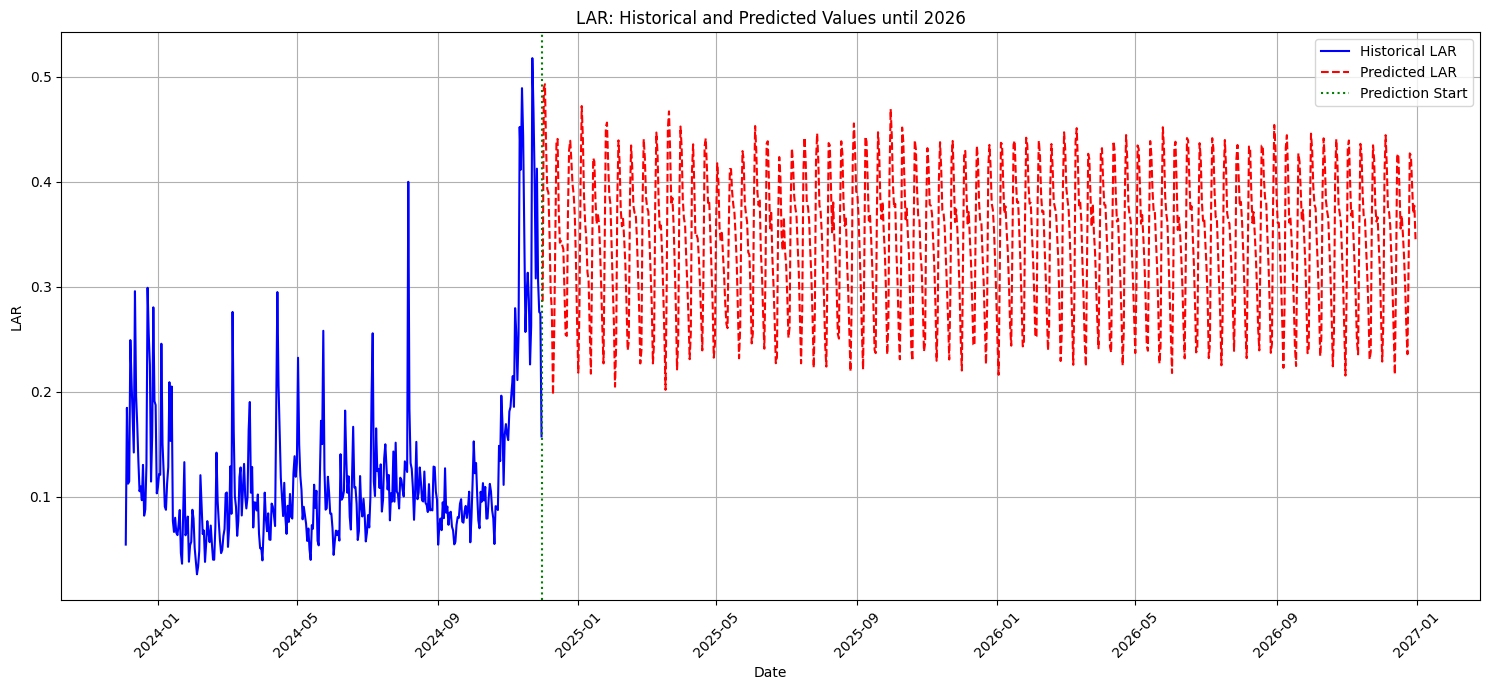


Predictions saved to '../../Dataset/Prediction_Data/Liquidity_Activity_Ratio/LAR_Future_Data_Demo.csv'

Prediction Summary:
Prediction Start Date: 2024-11-30
Prediction End Date: 2026-12-31
Number of days predicted: 761
Initial LAR: 0.16
Final Predicted LAR: 0.35
Minimum Predicted LAR: 0.20
Maximum Predicted LAR: 0.49


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random
import os
import datetime

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

config = config["lar_prediction"]

def set_seeds(seed=config["training"]["random_seed"]):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
    os.environ['TF_NUM_INTEROP_THREADS'] = '1'

set_seeds()

data = pd.read_csv(config["data"]["historical_data_path"])
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.set_index('Date', inplace=True)

timeseries_data = data['LAR'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
timeseries_data_scaled = scaler.fit_transform(timeseries_data)

def prepare_data(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i + n_steps])
        y.append(series[i + n_steps])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(config["model"]["lstm_units_1"], return_sequences=True, input_shape=input_shape),
        Dropout(config["model"]["dropout_rate_1"]),
        LSTM(config["model"]["lstm_units_2"], return_sequences=True),
        Dropout(config["model"]["dropout_rate_2"]),
        LSTM(config["model"]["lstm_units_3"]),
        Dense(config["model"]["dense_units"], activation='relu'),
        Dense(1, activation='relu')
    ])
    model.compile(
        optimizer=Adam(learning_rate=config["model"]["learning_rate"]),
        loss=config["model"]["loss_function"]
    )
    return model

def generate_future_predictions(model, last_sequence, n_steps, n_features, scaler, 
                              batch_size=config["forecast"]["batch_size"], 
                              end_date=datetime.datetime.strptime(config["forecast"]["forecast_end_date"], "%Y-%m-%d"), 
                              retrain=config["forecast"]["retrain"]):
    predictions_dict = {}  
    current_date = data.index[-1]
    
    current_sequence = last_sequence.reshape(1, n_steps, n_features)
    all_data_scaled = timeseries_data_scaled.copy()
    
    while current_date < end_date:
        batch_predictions = []
        batch_dates = []
        
        for _ in range(batch_size):
            current_date += pd.DateOffset(days=1)
            if current_date > end_date:
                break
                
            next_pred = model.predict(current_sequence, verbose=0)[0, 0]
            
            batch_predictions.append(next_pred)
            batch_dates.append(current_date)
            
            current_sequence = np.roll(current_sequence, -1, axis=1)
            current_sequence[0, -1, 0] = next_pred
        
        if not batch_predictions:  
            break
            
        batch_predictions = np.array(batch_predictions).reshape(-1, 1)
        batch_predictions_inv = scaler.inverse_transform(batch_predictions)
        
        for date, pred in zip(batch_dates, batch_predictions_inv.flatten()):
            predictions_dict[date] = pred
        
        if retrain:
            all_data_scaled = np.vstack([all_data_scaled, batch_predictions])
            
            X_new, y_new = prepare_data(all_data_scaled, n_steps)
            X_new = X_new.reshape((X_new.shape[0], X_new.shape[1], n_features))
            
            model.fit(X_new, y_new, epochs=5, batch_size=config["model"]["batch_size"], verbose=0)
            print(f"Model retrained - Current date: {current_date.strftime('%Y-%m-%d')}")

    predictions_series = pd.Series(predictions_dict, name='Predicted_LAR')
    predictions_series.index.name = 'Date'
    return predictions_series

n_steps = config["sequence"]["seq_length"]
n_features = 1
X, y = prepare_data(timeseries_data_scaled, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))

print("Training model on complete dataset...")
model = build_lstm_model((n_steps, n_features))
early_stopping = EarlyStopping(monitor='loss', patience=config["training"]["patience"], restore_best_weights=True)
history = model.fit(X, y, epochs=config["model"]["epochs"], batch_size=config["model"]["batch_size"], 
                    callbacks=[early_stopping], verbose=1)

print(f"\nGenerating predictions until {config['forecast']['forecast_end_date']}...")
last_sequence = timeseries_data_scaled[-n_steps:]
future_predictions = generate_future_predictions(
    model=model,
    last_sequence=last_sequence,
    n_steps=n_steps,
    n_features=n_features,
    scaler=scaler,
    batch_size=config["forecast"]["batch_size"],  
    end_date=datetime.datetime.strptime(config["forecast"]["forecast_end_date"], "%Y-%m-%d"),
    retrain=config["forecast"]["retrain"]
)

plt.figure(figsize=(15, 7))
plt.plot(data.index, data['LAR'], label='Historical LAR', color='blue')
plt.plot(future_predictions.index, future_predictions.values, 
         label='Predicted LAR', color='red', linestyle='--')
plt.axvline(x=data.index[-1], color='green', linestyle=':', label='Prediction Start')
plt.title('LAR: Historical and Predicted Values until 2026')
plt.xlabel('Date')
plt.ylabel('LAR')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

output_df = pd.DataFrame(future_predictions)
output_df.reset_index(inplace=True)
output_df.to_csv(config["data"]["prediction_output_path"], index=False)
print(f"\nPredictions saved to '{config['data']['prediction_output_path']}'")

print("\nPrediction Summary:")
print(f"Prediction Start Date: {data.index[-1].strftime('%Y-%m-%d')}")
print(f"Prediction End Date: {future_predictions.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of days predicted: {len(future_predictions)}")
print(f"Initial LAR: {data['LAR'].iloc[-1]:.2f}")
print(f"Final Predicted LAR: {future_predictions.iloc[-1]:.2f}")
print(f"Minimum Predicted LAR: {future_predictions.min():.2f}")
print(f"Maximum Predicted LAR: {future_predictions.max():.2f}")
